# Предсказание ликвидности активов банка

В этом домашнем задании мы немного поупражняемся с обработкой временных данных и базовыми моделями. 

В приложенном файле находится всего один временной ряд. Он представляет из себя срезы некоторых значений, связанных с движениями ликвидности одного крупного российского банка. Требуется построить модель, способную прогнозировать суммарное значение этого ряда за день. Данные достаточно сложные и хорошую модель на них построить непросто, но в учебных целях подойдут.

#### Описание бизнес-процесса, связанного с рядом.

Ликвидностью обычно называют высоколиквидные активы, т.е. активы, которые легко купить и продать, чтобы быстро конвертировать в деньги. Собственно, сами по себе деньги это тоже ликвидность. Но ими также могут быть ценные бумаги крупных компаний и деривативы на них. Для банков важно поддерживать некоторый уровень ликвидности, чтобы всегда иметь возможность либо быстро отдать краткосрочные долги. В то же время, ликвидные активы можно быстро вложить, если на рынке встретились хорошие условия. Если ликвидности избыток, её можно вложить, а если недостаток -- занять.

Прогнозная величина позволяет установить сумму (сальдо) поступлений и списаний за день. На основании прогноза позиционер (управляет ликвидностью) принимает решение о выделении средств на размещение на рынке для получения дополнительной прибыли. В случае, если на конец дня образуется профицит ликвидности, его можно разместить в ЦБ (дать в долг) по overnight ставке, равной ключевой-0.9%. В случае, если на конец дня образуется дефицит ликвидности (опасность не вернуть долги), его можно покрыть за счет займа по overnight ставке, равной ключевая+1%. 




In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sktime as sk
from statsmodels.tsa.seasonal import STL
from sktime.utils.plotting import plot_correlations


from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from catboost import  CatBoostRegressor
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sktime.transformations.series.holiday import CountryHolidaysTransformer

from bs4 import BeautifulSoup
import requests
import time
from selenium import webdriver as wd
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import warnings
warnings.simplefilter("ignore")

## 1) Загрузка данных (0.5 балла)

Загрузите временной ряд. Преобразуйте даты во временных данных. Какова частотность (frequency) данных и какой оффсет вы бы использовали? Не спешите отвечать на этот вопрос и посмотрите на данные **внимательно**. Выберите подходящий под данные оффсет и сделайте ресэмпл ряда к этому оффсету.

In [2]:
data = pd.read_csv("data_hw1_ts.csv")
display(data.head(10))
data.info()

,Date,Target
0,2017-01-09 09:00:00.000,0.000000
1,2017-01-09 11:00:00.000,-0.421841
2,2017-01-09 13:00:00.000,0.105555
3,2017-01-09 15:00:00.000,0.042276
4,2017-01-09 17:00:00.000,0.071416
5,2017-01-09 19:00:00.000,-0.376600
6,2017-01-09 21:00:00.000,0.000000
7,2017-01-09 23:00:00.000,0.000000
8,2017-01-10 09:00:00.000,0.000000
9,2017-01-10 11:00:00.000,-0.305344


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3909 entries, 0 to 3908
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3909 non-null   object 
 1   Target  3909 non-null   float64
dtypes: float64(1), object(1)
memory usage: 61.2+ KB


In [3]:
data['Date'] = pd.to_datetime(data['Date'])
data['Date'].describe(datetime_is_numeric=True)

count                             3909
mean     2018-02-11 07:33:50.698388224
min                2017-01-09 09:00:00
25%                2017-07-06 11:00:00
50%                2017-12-27 13:00:00
75%                2018-06-19 15:00:00
max                2020-09-17 00:00:00
Name: Date, dtype: object

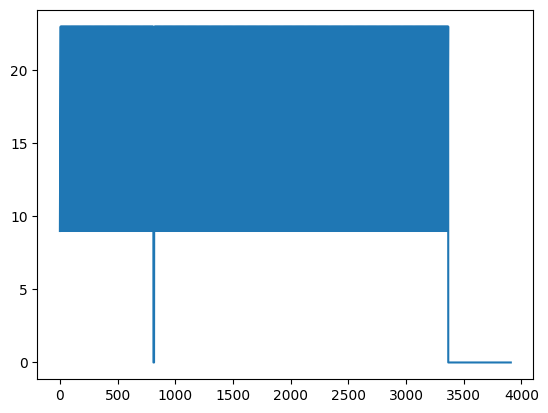

In [4]:
data['Date'].dt.hour.plot()
data = data.set_index('Date')

Как можем видеть на графике до последних пятисот записей данные измерялись несколько раз в промежутке с 9 до 21 часов, однако потом измерения стали единичными в 00 часов. Т.к. интересующая нас прогнозная величина вычисляется за день, но промежуток измерения равен 12 часов - я буду использовать ресемплирование по 12 часам с функцией суммы.

<Axes: xlabel='Date'>

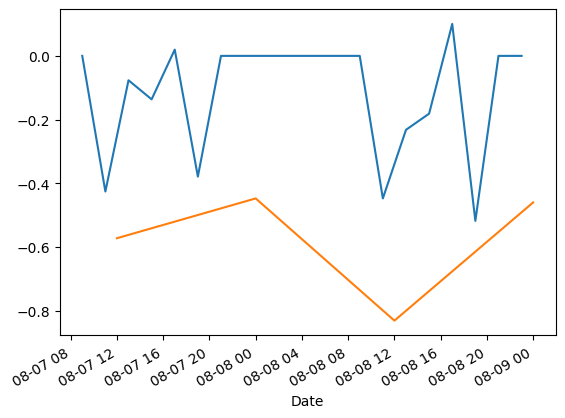

In [5]:
data.loc[(data.index>'2017-08-07')&(data.index<='2017-08-09'), 'Target'].plot();
data_12h = data.resample('12H').sum()
data_12h.loc[(data_12h.index>'2017-08-07')&(data_12h.index<='2017-08-09'), 'Target'].plot()


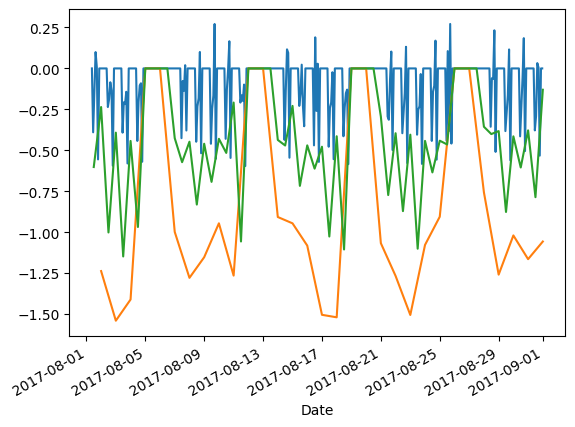

In [6]:
data_day = data.resample('1D').sum()
data.loc[(data.index>'2017-08')&(data.index<='2017-09'), 'Target'].plot()
data_day.loc[(data_day.index>'2017-08')&(data_day.index<='2017-09'), 'Target'].plot()
data_12h.loc[(data_12h.index>'2017-08')&(data_12h.index<='2017-09'), 'Target'].plot();


## 2) Визуальный анализ (0.5 балла)

Изобразите временной ряд, его автокорреляции и частные автокорреляции до порядка, который сочтёте нужным.

Что вы можете сказать о структуре ряда? Присутствует ли в нём тренд? Сезонность? Цикличность? Стационарность? (Хинт: на коррелограммах разностей ряда некоторые детали могут быть более чёткими). Ответьте на **каждый** вопрос.

<Axes: xlabel='Date'>

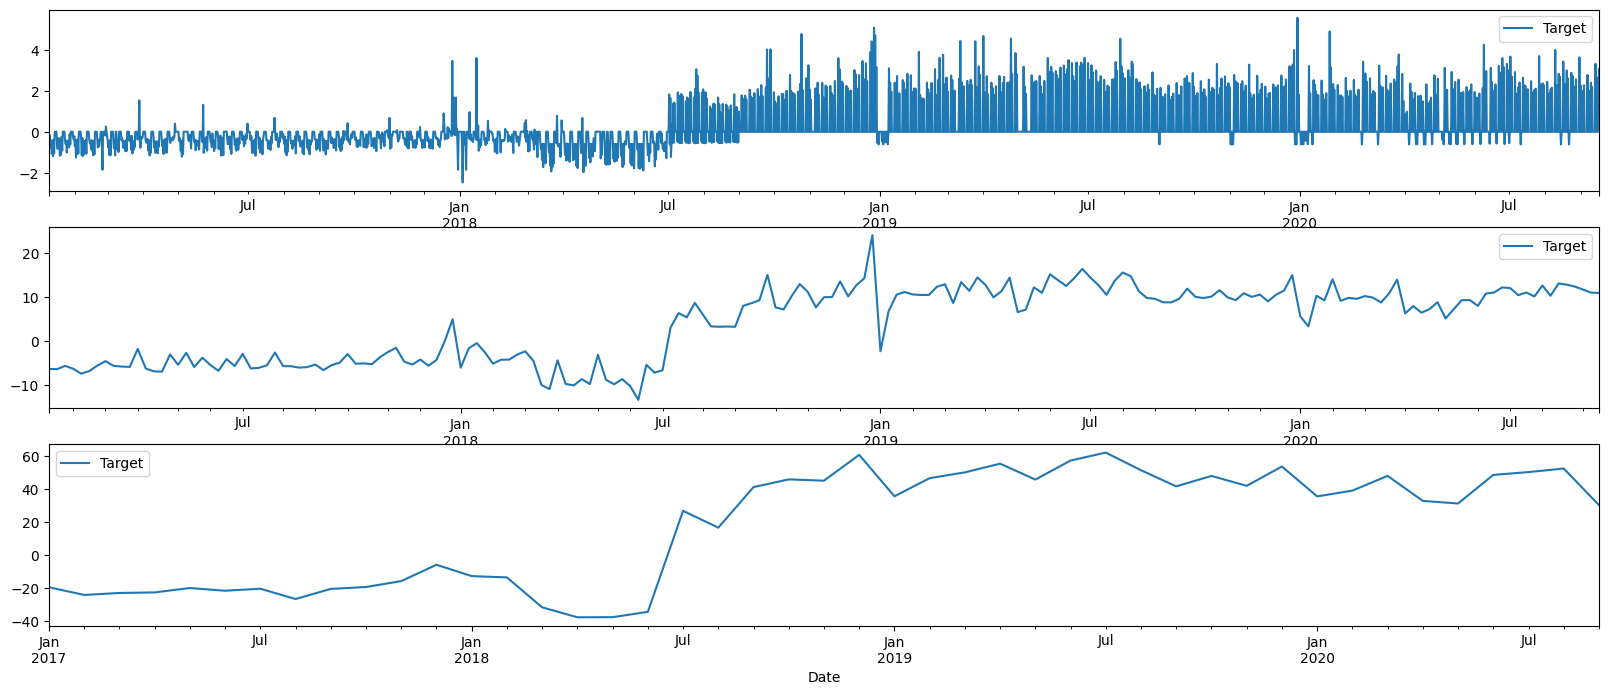

In [7]:
#data_day.plot()
fig, axes = plt.subplots(3,1, figsize=(20,8))
data_12h.plot(ax = axes[0])
data_12h.resample('1W').sum().plot(ax = axes[1])
data_12h.resample('1M').sum().plot(ax = axes[2])

В данных в июне 2018 года наблюдается структурный сдвиг, характеризующийся значительным изменением поведения показателя ликвидности. Также можем отметить особенность значительного провала показателя каждый январь (что, возможно, связано с праздниками в РФ)

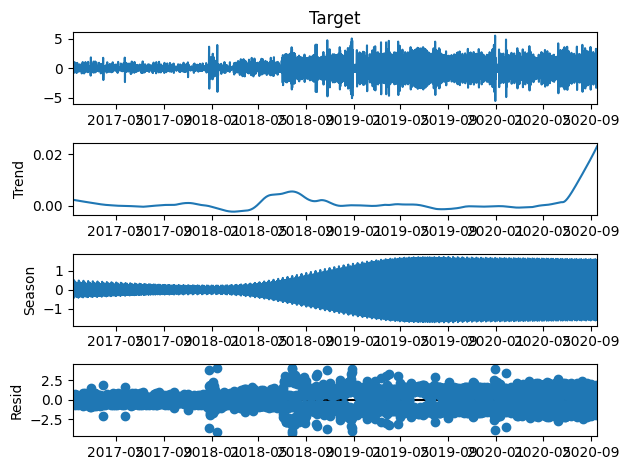

In [8]:
stl = STL(data_12h['Target'].diff().dropna(),trend=365, seasonal=61)
res = stl.fit()
res.plot();

plt.rcParams["figure.figsize"] = (20,20)

В данных присутствует тренд, отчетливо наблюдается сезонность и цикличность
Рассматриваемый ряд из-за наличия структурного сдвига не является стационарным, математическое ожидание ряда и дисперсия после сдвига притерпели изменения.

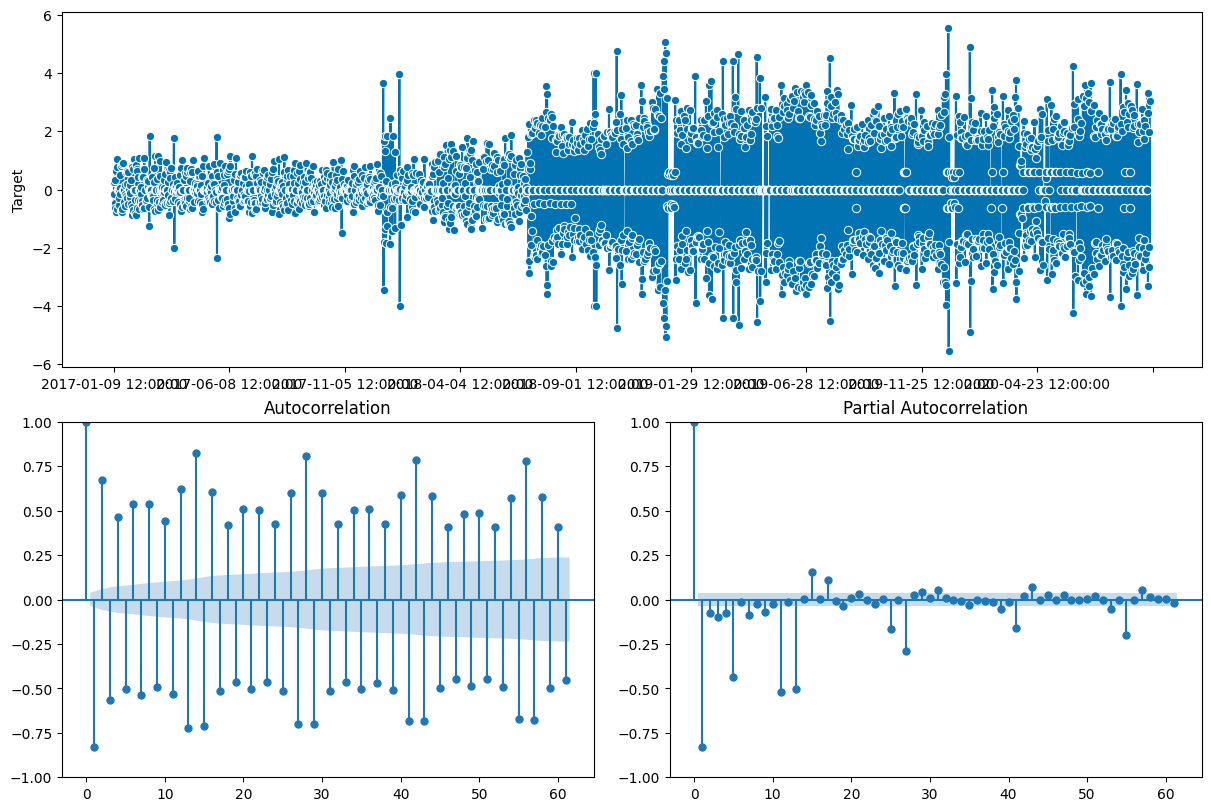

In [9]:
plot_correlations(data_12h['Target'].diff().dropna(), lags = 61);

График автокорреляции показывает сильное влияние сезонной составляющей на поведение ряда. Каждые 7 дней наблюдается высокая положительная автокорреляция. При генерации признаков стоит учесть эту особенность данных.

## 3) Генерация признаков (3 балла)

Внимание! При наличии хотя бы одной утечки в данном блоке стоимость всех пунктов делится на 2, кроме бонусного. Итого максимальный балл при наличии утечек равен 1.5 (или 2.5 при сделанном бонусе).


Создайте следующие признаки. Не забудьте лагировать необходимые фичи. Календарные фичи утечками не являются и могут даже заглядывать в будущее. Фичи с утечками не засчитываются. Выбор каждой фичи необходимо обосновать. Фичи без обоснования не засчитываются.

1) Календарные фичи:
<ul>
<li>Придумайте 5 календарных фичей. (0.15 за каждую)</li>
<li>В середине ряда явно есть структурное изменение. Попробуйте придумать фичу, которая бы помогла это учесть. (0.15 балла)</li>
<li>Бонус! (1 балл) Одна из важных календарных фичей наряду с праздниками -- налоговые (бухгалтерские) дни. Найти их в удобном для чтения формате весьма проблемно, придётся парсить, но это весьма сильная фича. Код парсинга (или описание того, как вы их выкачивали) необходимо приложить, иначе пункт не засчитывается.</li>
</ul>

2) Лаги таргета (до 5 разных). (0.1 за все сразу вне зависимости от количества) 

3) Экзогенные фичи (по 0.5 балла каждый пункт):
<ul>
<li>Значение ключевой ставки. Можно поискать на сайте ЦБ</li>
<li>Обменнык курс доллара. Тоже есть на сайте ЦБ либо в любом другом источнике. Например. YahooFinance</li>
<li>Спред ставок MosЗrime, все 7 показателей. Ставка MosPrime -- ставка кредитования в рублях на межбанковском рынке России. Спред -- разница между ставками кредита и депозита. У mosprime есть свой сайт.</li>
</ul>

4) Придумайте сами 2 различных фичи (по 0.25 за каждую). Выбор каждой фичи кратко обоснуйте.

### 3.1 Календарные признаки.

#### Признаки, полученные из дат

In [10]:
data_12h['rolling_mean'] = data_12h['Target'].shift().rolling(30).mean()
data_12h['day_of_week'] = data_12h.index.dayofweek
data_12h['month'] =  data_12h.index.month
data_12h['year'] =  data_12h.index.year

In [11]:
holidays = CountryHolidaysTransformer("RUS").fit_transform(data_12h)  

In [12]:
data_12h['holiday'] = holidays['RUS_holidays'].values

#### Налоговые (бухгалтерские) дни

In [13]:
urls = ['https://www.consultant.ru/document/cons_doc_LAW_208577/',
        'https://www.consultant.ru/document/cons_doc_LAW_284538/',
        'https://www.consultant.ru/document/cons_doc_LAW_312984/',
        'https://www.consultant.ru/document/cons_doc_LAW_339977/']

In [14]:
years = ['2017', '2018', '2019', '2020']

month = {'января':'01', 
         'февраля':'02',
         'марта':'03',
         'апреля':'04',
         'мая':'05',
         'июня':'06',
         'июля':'07',
         'августа':'08',
         'сентября':'09',
         'октября':'10',
         'ноября':'11',
         'декабря':'12'}

In [15]:
def get_dates(i, block_text):
    year = years[i]
    dates_list = []
    for block in block_text:
        if block[0].isnumeric():
            block_list = block.split(' ')
            if len(block_list[0]) < 2:
                block_list[0] = '0' + block_list[0]
            block_list[1] = month[block_list[1].lower()]
            if len(block_list) > 2:
                date_str = "-".join(block_list[:-1] + [year])
            else:
                date_str = "-".join(block_list + [year])
            date_object = datetime.strptime(date_str, '%d-%m-%Y').date()
            dates_list.append(date_object)
    return dates_list

In [16]:
dates = []
for i, url in enumerate(urls):
    page = requests.get(url)
    soup = BeautifulSoup(page.text, "html.parser")
    blocks = soup.findAll(class_ = "document-page__toc")
    blocks = blocks[0].find_all("li")
    block_text = [block.text for block in blocks]
    dates = dates + get_dates(i, block_text)
tax_dates = pd.DataFrame(dates, columns=['date'])
tax_dates['tax_date'] = True
tax_dates['date'] = pd.to_datetime(tax_dates['date'])
tax_dates['tax_date'] = tax_dates['tax_date'].astype('bool')
tax_dates

,date,tax_date
0,2017-01-09,True
1,2017-01-13,True
2,2017-01-16,True
3,2017-01-18,True
4,2017-01-20,True
...,...,...
397,2020-12-24,True
398,2020-12-25,True
399,2020-12-28,True
400,2020-12-30,True


### 3.2 Лаги таргета

In [17]:
for lag in [1, 2, 5, 7, 31]:
    data_12h['lag_{}'.format(lag)] = data_12h['Target'].shift(lag)
data_12h = data_12h.reset_index()
data_12h = data_12h.rename(columns={'Date':'date', 'Target':'target'})
data_12h

,date,target,rolling_mean,day_of_week,month,year,holiday,lag_1,lag_2,lag_5,lag_7,lag_31
0,2017-01-09 00:00:00,-0.421841,NaN,0,1,2017,False,NaN,NaN,NaN,NaN,NaN
1,2017-01-09 12:00:00,-0.157353,NaN,0,1,2017,False,-0.421841,NaN,NaN,NaN,NaN
2,2017-01-10 00:00:00,-0.305344,NaN,1,1,2017,False,-0.157353,-0.421841,NaN,NaN,NaN
3,2017-01-10 12:00:00,-0.776916,NaN,1,1,2017,False,-0.305344,-0.157353,NaN,NaN,NaN
4,2017-01-11 00:00:00,-0.446489,NaN,2,1,2017,False,-0.776916,-0.305344,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2690,2020-09-15 00:00:00,2.644602,0.871430,1,9,2020,False,0.000000,3.307929,0.000000,0.0,0.000000
2691,2020-09-15 12:00:00,0.000000,0.838861,1,9,2020,False,2.644602,0.000000,0.000000,0.0,3.621653
2692,2020-09-16 00:00:00,1.977839,0.838861,2,9,2020,False,0.000000,2.644602,0.000000,0.0,0.000000
2693,2020-09-16 12:00:00,0.000000,0.829440,2,9,2020,False,1.977839,0.000000,3.307929,0.0,2.260492


### 3.3 Экзогенные фичи

#### Значение ключевой ставки.

In [18]:
url = 'https://www.cbr.ru/hd_base/KeyRate/?UniDbQuery.Posted=True&UniDbQuery.From=01.01.2017&UniDbQuery.To=31.12.2020'
page = requests.get(url)
soup = BeautifulSoup(page.text, "html.parser")
blocks = soup.findAll(class_ = "data")
blocks_list = [" ".join(i.text.split('\n')[1:3]) for i in blocks[0]]
blocks_list = [i.split(" ") for i in blocks_list if i]

In [19]:
cbr_course = pd.DataFrame(blocks_list[1:], columns = blocks_list[0])
cbr_course['Дата'] = pd.to_datetime(cbr_course['Дата'])
cbr_course['Ставка'] = cbr_course['Ставка'].apply(lambda x: x.replace(',','.'))
cbr_course = cbr_course.rename(columns = {'Дата':'date', 'Ставка':'cbr_rate'})
cbr_course['cbr_rate'] = cbr_course['cbr_rate'].astype('float')
cbr_course

,date,cbr_rate
0,2020-12-31,4.25
1,2020-12-30,4.25
2,2020-12-29,4.25
3,2020-12-28,4.25
4,2020-12-25,4.25
...,...,...
987,2017-01-13,10.00
988,2017-12-01,10.00
989,2017-11-01,10.00
990,2017-10-01,10.00


#### Обменный курс доллара.

In [20]:
cbr_dollar = pd.read_excel('cbr_dollar.xlsx', engine="openpyxl")
cbr_dollar = cbr_dollar.drop(columns = ['nominal', 'cdx'])
cbr_dollar = cbr_dollar.rename(columns = {'data':'date', 'curs':'usd_rate'})
cbr_dollar

,date,usd_rate
0,2020-12-31,73.8757
1,2020-12-30,73.6567
2,2020-12-29,73.7175
3,2020-12-26,73.6921
4,2020-12-25,74.8392
...,...,...
978,2017-01-14,59.3700
979,2017-01-13,59.4978
980,2017-01-12,60.1614
981,2017-01-11,59.9533


Данные получены с сайта ЦБ РФ в виде файла .xlsx

#### Спред ставок MosЗrime.

In [39]:
url = 'http://www.cbr.ru/hd_base/mosprime-spread/?UniDbQuery.Posted=True&UniDbQuery.From=01.01.2017&UniDbQuery.To=30.12.2022'
browser = wd.Chrome()
browser.get(url)
element = WebDriverWait(browser, 600).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, '[class="table-wrapper"]')))
soup = BeautifulSoup(browser.page_source, 'html.parser')
blocks = soup.findAll(class_="table-wrapper")

In [40]:
blocks_list = [i.text.split('\n') for i in blocks[1]]

In [41]:
blocks_list_prep = []
temp_list = []
for x in blocks_list[1]:
    if x!='':
        if x == ' — ':
            x = np.nan
            temp_list.append(x)
        else:
            temp_list.append(x.replace(",", "."))
    else:
        if temp_list:
            blocks_list_prep.append(temp_list)
            temp_list=[]
mosprime_rate = pd.DataFrame(blocks_list_prep[1:], columns = blocks_list_prep[0])
mosprime_rate = mosprime_rate.rename(columns={'Дата использованного значения MosPrime':'Дата'})
mosprime_rate['Дата'] = pd.to_datetime(mosprime_rate['Дата'])
mosprime_rate = mosprime_rate[mosprime_rate['Дата'] < '2021-01-01']
columns = {'Дата':'date',
           '1 день':'mp_rate_1d',
           '1 нед.':'mp_rate_1w',
            '2 нед.':'mp_rate_2w',
            '1 мес.':'mp_rate_1m',
            '2 мес.':'mp_rate_2m',
            '3 мес.':'mp_rate_3m',
            '6 мес.':'mp_rate_6m'}
for column in mosprime_rate.columns[1:]:
    mosprime_rate[column] = mosprime_rate[column].astype('float')
mosprime_rate = mosprime_rate.rename(columns = columns)
mosprime_rate

,date,mp_rate_1d,mp_rate_1w,mp_rate_2w,mp_rate_1m,mp_rate_2m,mp_rate_3m,mp_rate_6m
492,2020-12-30,0.26,0.33,0.38,0.47,0.50,0.67,0.80
493,2020-12-29,0.26,0.33,0.38,0.47,0.50,0.67,0.80
494,2020-12-28,0.26,0.33,0.38,0.47,0.50,0.67,0.80
495,2020-12-25,0.26,0.33,0.38,0.47,0.50,0.67,0.80
496,2020-12-24,0.26,0.33,0.38,0.47,0.50,0.67,0.80
...,...,...,...,...,...,...,...,...
1465,2017-01-13,0.24,0.36,0.44,0.67,0.59,0.94,1.00
1466,2017-12-01,0.24,0.36,0.44,0.67,0.59,0.94,1.00
1467,2017-11-01,0.24,0.36,0.45,0.67,0.59,0.95,1.00
1468,2017-10-01,0.24,0.36,0.45,0.67,0.59,0.95,1.00


#### Итоговый датасет

In [42]:
df = data_12h.merge(mosprime_rate, how='left').merge(cbr_dollar, how='left').merge(cbr_course, how='left').merge(tax_dates, how='left')
df['tax_date'] = df['tax_date'].fillna(False)

nan_col = ['mp_rate_1d',
           'mp_rate_1w',
           'mp_rate_2w',
           'mp_rate_1m',
           'mp_rate_2m',
           'mp_rate_3m',
           'mp_rate_6m',
           'usd_rate',
           'cbr_rate']

for column in nan_col:
    try:
        df[column] = df[column].fillna(method = 'ffill')
    except:
        pass

In [43]:
df_result = df.dropna()
df_result['tax_date'] = df_result['tax_date'].astype('bool')
df_result.shape
df_result = df_result.set_index('date')

In [44]:
df_result.columns

Index(['target', 'rolling_mean', 'day_of_week', 'month', 'year', 'holiday',
       'lag_1', 'lag_2', 'lag_5', 'lag_7', 'lag_31', 'mp_rate_1d',
       'mp_rate_1w', 'mp_rate_2w', 'mp_rate_1m', 'mp_rate_2m', 'mp_rate_3m',
       'mp_rate_6m', 'usd_rate', 'cbr_rate', 'tax_date'],
      dtype='object')

Таким образом мы получили итоговый датасет в табличной форме с обработанными пропусками, который будет использоваться для обучения моделей.

## 4) Одношаговое прогнозирование (1 балл)

Внимание! Запрещается пользоваться функцией make_reduction из sktime. Пункты Регрессия и Бенчмарк не будут засчитаны! 

#### 4.1) Предобработка (0.3 балла)

Разбейте полученные данные на трейн и тест по времени. Размер теста: 0.2. Если необходимо, отнормируйте данные. Если необходимо, закодируйте категориальные фичи любым валидным методом.

In [45]:
features = df_result.drop(['target'], axis = 1)
target = df_result['target']

features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2664 entries, 2017-01-24 12:00:00 to 2020-09-17 00:00:00
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   rolling_mean  2664 non-null   float64
 1   day_of_week   2664 non-null   int64  
 2   month         2664 non-null   int64  
 3   year          2664 non-null   int64  
 4   holiday       2664 non-null   bool   
 5   lag_1         2664 non-null   float64
 6   lag_2         2664 non-null   float64
 7   lag_5         2664 non-null   float64
 8   lag_7         2664 non-null   float64
 9   lag_31        2664 non-null   float64
 10  mp_rate_1d    2664 non-null   float64
 11  mp_rate_1w    2664 non-null   float64
 12  mp_rate_2w    2664 non-null   float64
 13  mp_rate_1m    2664 non-null   float64
 14  mp_rate_2m    2664 non-null   float64
 15  mp_rate_3m    2664 non-null   float64
 16  mp_rate_6m    2664 non-null   float64
 17  usd_rate      2664 non-null   float

In [46]:
target_train, target_test, features_train, features_test = train_test_split(target, features, shuffle=False, test_size=0.2)

scaler = MinMaxScaler()

cat_features = [
    'month',
    'day_of_week',
    'year',
    'holiday',
    'tax_date']

num_features = [column for column in features.columns if column not in cat_features]

features_train[num_features] = scaler.fit_transform(features_train[num_features])
features_test[num_features] = scaler.transform(features_test[num_features])

In [47]:

print(features_train.shape)
print(features_test.shape)

(2131, 20)
(533, 20)


#### 4.2) Регрессия (0.3 балла)

Выберите ваш любимый регрессор и решите задачу одношагового прогнозирования. При необходимости подберите гиперпараметры. Кросс-валидацию мы ещё пройти не успели, поэтому можно отбирать параметры на тесте, держа в голове, что так делать не очень хорошо. Подсчитайте качество одношаговых прогнозов. Метрика -- MAPE. 

In [48]:
model = CatBoostRegressor(iterations=50, 
                          depth=2, 
                          learning_rate=0.5,
                         random_state=12345)
def neg_mape_scorer():
    return make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [49]:
model.fit(features_train, target_train, cat_features=cat_features, verbose=0)
target_prediction = pd.Series(model.predict(features_test), index=target_test.index)
print("MAPE: ", mean_absolute_percentage_error(target_test, target_prediction))

MAPE:  471060164346182.56


In [50]:
tscv = TimeSeriesSplit(n_splits = 5)
model = CatBoostRegressor(random_state=12345)

params = {"depth" : [5, 6, 7, 8],
          "n_estimators" : [50, 150, 200, 300]}
gr_s = GridSearchCV(model, params, scoring = neg_mape_scorer(), cv=tscv)
gr_s.fit(features_train, target_train, verbose=0)
print("Лучшие параметры модели: ", gr_s.best_params_)
print("MAPE: ", gr_s.best_score_*(-1))

Лучшие параметры модели:  {'depth': 6, 'n_estimators': 300}
MAPE:  296199177517168.8


#### 4.3) Бенчмарк (0.3 балла)

Постройте прогноз с помощью наивной модели. Наивная модель в качестве прогноза возвращает последнее доступное на текущий момент значение из трейна (по сути, фичу первого лага таргета). Подсчитайте качество такого прогноза и сравните с вашей моделью. Если вы всё сделали правильно, то должно получиться как минимум не хуже. С налоговыми датами почти наверное получится лучше.




In [51]:
print("MAPE: ", mean_absolute_percentage_error(target_test, target.tail(len(target_test)).shift(1).fillna(0)))

MAPE:  3514432864419492.5


#### 4.4) Визуализация (0.1 балла)

Визуализируйте на одном графике тестовые данные, прогноз вашей модели и прогноз наивной модели. Подпишите все оси.

In [52]:
target_prediction = pd.Series(gr_s.best_estimator_.predict(features_test), index=target_test.index)

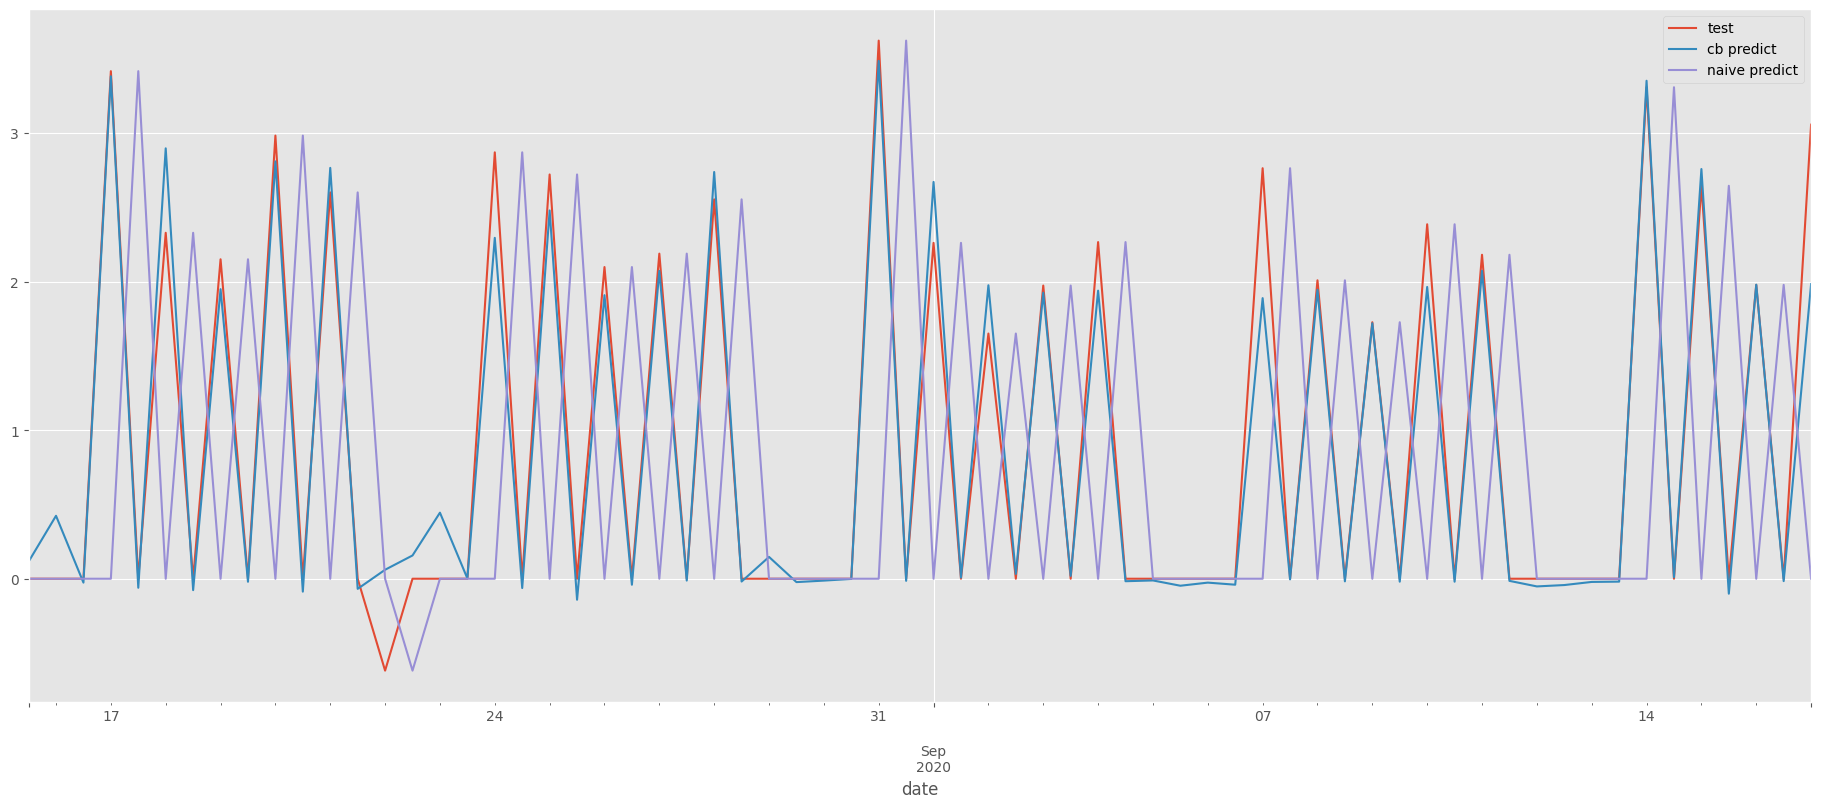

In [53]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (23,9)
target_test[target_test.index>'2020-08-15'].plot(label='test')
target_prediction[target_prediction.index>'2020-08-15'].plot(label='cb predict')
target[target.index >'2020-08-15' ].tail(len(target_test)).shift(1).fillna(0).plot(label='naive predict')
plt.legend();

## 5) Многошаговое прогнозирование

#### 5.1) Повтор препроцессинга (0 баллов)

Вернёмся к полному датасету. Повторите разбиение на трейн и тест. Размер теста: 15 наблюдений. Оставьте в модели только календарные фичи и лаги таргета. Повторите нормирование и энкодинг, если делали их ранее и если это необходимо. 

In [54]:
features = features.drop(columns=features.columns[10:].values)
features.head()

,rolling_mean,day_of_week,month,year,holiday,lag_1,lag_2,lag_5,lag_7,lag_31
date,,,,,,,,,,
2017-01-24 12:00:00,-0.453692,1,1,2017,False,-0.446441,-0.597780,0.000000,0.000000,-0.421841
2017-01-25 00:00:00,-0.482381,2,1,2017,False,-1.018033,-0.446441,0.000000,0.000000,-0.157353
2017-01-25 12:00:00,-0.486573,2,1,2017,False,-0.431118,-1.018033,-0.440918,0.000000,-0.305344
2017-01-26 00:00:00,-0.482407,3,1,2017,False,-0.651909,-0.431118,-0.597780,0.000000,-0.776916
2017-01-26 12:00:00,-0.482842,3,1,2017,False,-0.459552,-0.651909,-0.446441,-0.440918,-0.446489


In [55]:
target_train, target_test, features_train, features_test = train_test_split(target, features, shuffle=False, test_size=15)

scaler = MinMaxScaler()

cat_features = [
    'month',
    'day_of_week',
    'year',
    'holiday',
    'tax_date']

num_features = [column for column in features.columns if column not in cat_features]

features_train[num_features] = scaler.fit_transform(features_train[num_features])
features_test[num_features] = scaler.transform(features_test[num_features])

#### 5.2) Рекурсивная стратегия (2.5 балла)

Внимание! Запрещается пользоваться функцией make_reduction из sktime. Рекурсивную стратегию необходимо написать вручную!

 Реализуйте рекурсивное прогнозирование на 15 шагов с помощью вашей любимой регрессионной модели.

In [56]:
features_recursieve = pd.concat([features_train, features_test])
features_recursieve.loc["2020-09-10 12:00:00":,["rolling_mean", "lag_1", "lag_2", "lag_5","lag_7","lag_31"]] = np.nan	
features_recursieve

,rolling_mean,day_of_week,month,year,holiday,lag_1,lag_2,lag_5,lag_7,lag_31
date,,,,,,,,,,
2017-01-24 12:00:00,0.157061,1,1,2017,False,0.252476,0.233609,0.308130,0.308130,0.255542
2017-01-25 00:00:00,0.143260,2,1,2017,False,0.181220,0.252476,0.308130,0.308130,0.288514
2017-01-25 12:00:00,0.141243,2,1,2017,False,0.254386,0.181220,0.253164,0.308130,0.270065
2017-01-26 00:00:00,0.143248,3,1,2017,False,0.226861,0.254386,0.233609,0.308130,0.211278
2017-01-26 12:00:00,0.143038,3,1,2017,False,0.250841,0.226861,0.252476,0.253164,0.252470
...,...,...,...,...,...,...,...,...,...,...
2020-09-15 00:00:00,NaN,1,9,2020,False,NaN,NaN,NaN,NaN,NaN
2020-09-15 12:00:00,NaN,1,9,2020,False,NaN,NaN,NaN,NaN,NaN
2020-09-16 00:00:00,NaN,2,9,2020,False,NaN,NaN,NaN,NaN,NaN


In [57]:
target_prediction = pd.Series(np.nan, index=target_test.index)
target_recursieve = pd.concat([target_train, target_prediction])
target_recursieve

date
2017-01-24 12:00:00   -1.018033
2017-01-25 00:00:00   -0.431118
2017-01-25 12:00:00   -0.651909
2017-01-26 00:00:00   -0.459552
2017-01-26 12:00:00   -0.760429
                         ...   
2020-09-15 00:00:00         NaN
2020-09-15 12:00:00         NaN
2020-09-16 00:00:00         NaN
2020-09-16 12:00:00         NaN
2020-09-17 00:00:00         NaN
Length: 2664, dtype: float64

In [58]:
model = CatBoostRegressor(iterations=50, 
                          depth=2, 
                          learning_rate=0.5,
                         random_state=12345)
model.fit(features_train, target_train, verbose=0)

In [59]:
for i in range(15):
    target_recursive.loc[target_test.index[i]] = model.predict(features_test.loc[target_test.index[i]])
    if i < 14:
        features_recursive.loc[target_test.index[i+1], 'rolling_mean'] = target_recursive.shift().rolling(30).mean()[target_test.index[i+1]]
        for lag in [1, 2, 5, 7, 31]:
            features_recursive.loc[target_test.index[i+1],'lag_{}'.format(lag)] = target_recursive.shift(lag)[target_test.index[i+1]]

In [60]:
recursive_prediction = target_recursive[target_test.index]
print("MAPE: ", mean_absolute_percentage_error(target_test, recursive_prediction))

MAPE:  173262671862633.84


#### 5.3) Прямая стратегия (2 балла)

Внимание! Запрещается пользоваться функцией make_reduction из sktime. Прямую стратегию необходимо написать вручную!

 Реализуйте прямое прогнозирование на 15 шагов с помощью вашей любимой регрессионной модели.

In [91]:
direct_prediction = []
for i in range(1,16):
    regressor = LinearRegression()
    regressor.fit(features_train[:-i], target_train.shift(-i).dropna())
    direct_prediction.append(*regressor.predict(features_test.loc['2020-09-10 00:00:00'].values.reshape(1, -1)))

In [92]:
direct_prediction = pd.Series(direct_prediction, index=target_test.index)
print("MAPE: ", mean_absolute_percentage_error(target_test, direct_prediction))

MAPE:  3431647580921143.5


#### 5.4) Результаты (0.5 балла)

Визуализируйте прогнозы двух стратегий и тестовые данные на одном графике. Подсчитайте MAPE прогнозов двух моделей. Какая оказалась лучше?

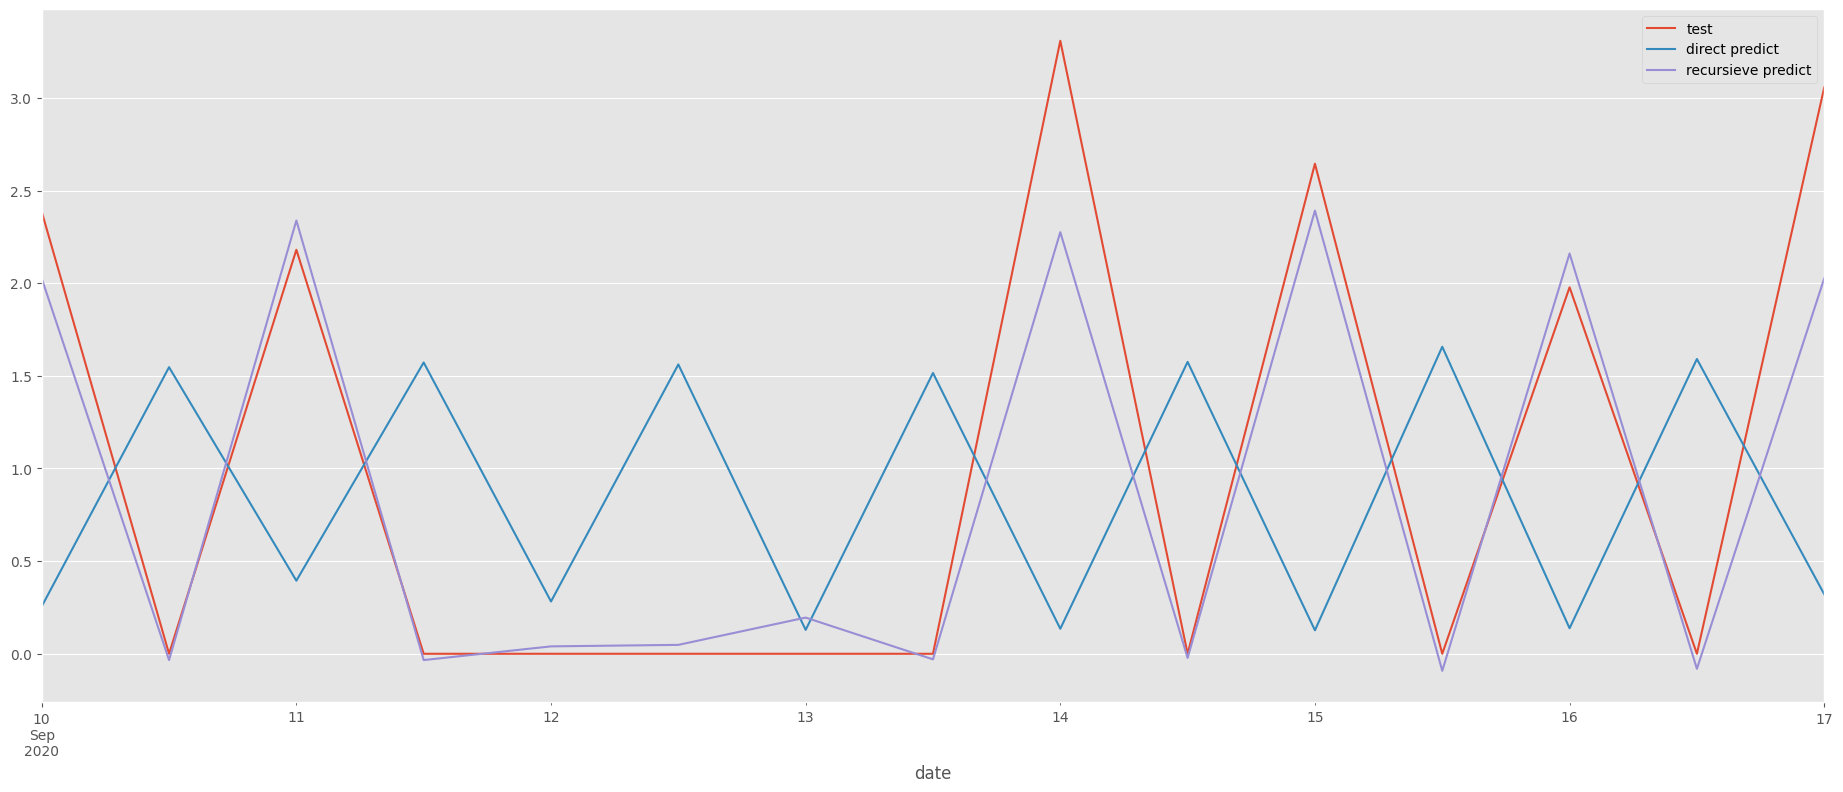

In [93]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (23,9)
target_test.plot(label='test')
direct_prediction.plot(label='direct predict')
recursive_prediction.plot(label='recursieve predict')
plt.legend();

Рекусивная стратегия смогла построить более точный прогноз.